<a href="https://colab.research.google.com/github/DanielHolzwart/VGG19-Class-Activation-Map-and-filter-display/blob/main/vgg19_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In this workbook, we will apply the Class Activation Function (=CAM) to a picture of dogs. CAM lets us see at pictures through the eyes of a convolutional neural network and highlights the parts of the picture which are most prudant to classify a picture. Phrased differently, we want to see the dogs in the picture below highlighted in red.

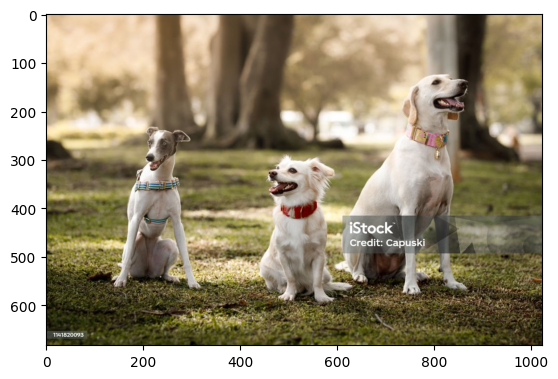

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
image = Image.open(str('dogs.jpg'))
plt.imshow(image)

The class activation function is a neat tool that shows how the neural network comes to the decission that certain parts of the picture belong to the class it is trying to detect, e.g., a dog. Via a heatmap we will nicely see this. Let's see whether the 'iStock' box in the picture distract the neural network

The network we will be using is going to be the vgg19 network which has 1000 classes as outputs from ImageNet. As I am no dog expert, I am not sure whether the dogs you see above are also in the classes. However, there are certainly dogs in the classes and the neural network will most likely detect dogs which are most similar to the existing classes. Notice that we do not train the network and only manipulate data.

In [4]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets

Even though we will be looking only at a single picture, it is convenient to still use the Imagefolder function for this. 'data_dogs' is the folder containing the single picture

In [5]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=0, std=1)])

# define a 1 image dataset
dataset = datasets.ImageFolder(root='data_dogs', transform=transform)

# define the dataloader to load that single image
dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)

Due to normalization of the picture looks distorted now

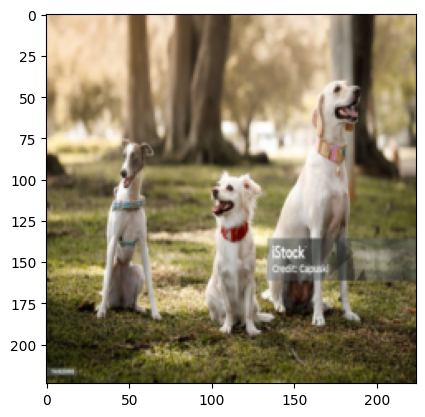

In [6]:
for x_batch, _ in dataloader:
  plt.imshow(x_batch.squeeze().permute(1,2,0).numpy())

We are going to use the pretrained vgg19 model. Let us have a look at the vgg19 model. Parts of the following codes are motivated by https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82

In [7]:
vgg19(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:08<00:00, 70.1MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

We are interest in the output of activation function of the last convolutional layers, before applying the MaxPooling. The idea of the following code is to basically seperate the network into the vgg19.features part and vgg19.classifier part. In between pulling those apart, we activate the hook function to get the gradients in the backward pass from the last convolutional layer.

In [45]:
class VGG_cam(nn.Module):
    def __init__(self):
        super(VGG_cam, self).__init__()

        # get the pretrained vgg19 network
        self.vgg = vgg19(pretrained=True)

        # from the above output the last layer before applying max pooling is 35. Safe them in the following variable
        self.features_conv = self.vgg.features[:35]

        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier

        # placeholder for the gradients
        self.gradients = None

    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features_conv(x)


        # register the hook and save them in the gradients variable
        h = x.register_hook(self.activations_hook)

        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x

    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients

    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

Lets initialize the model and get the prediciton.

In [9]:
# initialize the VGG model
vgg = VGG_cam()

# set the evaluation mode
vgg.eval()

# get the image from the dataloader
img, _ = next(iter(dataloader))

# get the most likely prediction of the model
pred = vgg(img)

The output number correspondce to a particular breed of dog in the imagenet dataset.

In [10]:
pred.argmax(dim=1).item()

974

To display the class activation map, we need to highlight the pixels which are most import to the CNN. To do this, we will weight the output of the last convolutional network by the gradients.

In [11]:
# get the gradient of the output with respect to the parameters of the model
pred = vgg(img)
index = pred.argmax(dim=1).item()
pred[:, index].backward()

# pull the gradients out of the model
gradients = vgg.get_activations_gradient()
gradients.shape

# pool the gradients across the channels. The output of the following formula is the weight we multiply to the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = vgg.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]

# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

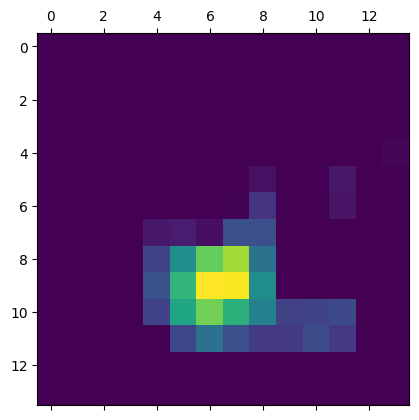

In [13]:
plt.matshow(heatmap.squeeze())

Finally, we overlay the heatmap over the picture of dogs.

In [14]:
import cv2
img = cv2.imread('./data_dogs/dog/dogs.jpg')
heatmap = cv2.resize(heatmap.numpy(), (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

In [15]:
import cv2
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
heatmap_RGB = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)


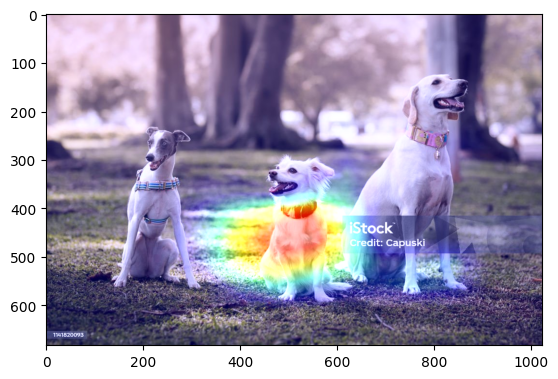

In [16]:
overlay = cv2.addWeighted(img_RGB, 1, heatmap_RGB, .5, 0);
plt.imshow(overlay)

Now we see how the CNN came to the conclusion that the picture is a dog! In particular, the collar is in the highlighted area, mich makes sense as this is usually a dog sign.

In [ ]:
#---------------------------------------------------------------------------------------------------#

Here we will slightly adjust the VGG model from above. We will add to more functions to the class which enable us to extract the convolutional layers and features. This will allows us to plot filters.

In [18]:
from torchvision import models

In [56]:
class VGG_extended(nn.Module):
    def __init__(self):
        super(VGG_extended, self).__init__()

        # get the pretrained vgg19 network
        self.vgg = vgg19(pretrained=True)

        # from the above output the last layer before applying max pooling is 35. Safe them in the following variable
        self.features_conv = self.vgg.features[:35]

        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier

        # placeholder for the gradients
        self.gradients = None

    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features_conv(x)

        # register the hook and save them in the gradients variable
        h = x.register_hook(self.activations_hook)

        # apply the remaining pooling
        x = x.view((1, -1))
        x = self.classifier(x)
        return x

    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients

    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

    # method for the convolutional layers exctraction
    def get_conv_layers(self):
        conv_layers = []
        for i in range(len(self.vgg.features)):
            if type(self.vgg.features[i]) == nn.Conv2d:
                conv_layers.append(self.vgg.features[i])
        return conv_layers

    # method for the features exctraction
    def get_features(self,x):
        layers = self.get_conv_layers()
        features = []
        for layer in layers:
            x = layer(x)
            features.append(x)
        return features

Let us check wether the layer extraction works

In [52]:
layers = VGG_extended().get_conv_layers()
print(layers)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(512, 512, kernel_size=(3, 3), st

Reload the picture

In [62]:
img, _ = next(iter(dataloader))

Some data prepocessing to have nicer pictures

In [63]:
processed = []
for feature_map in VGG_extended().get_features(img):
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.detach().numpy())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


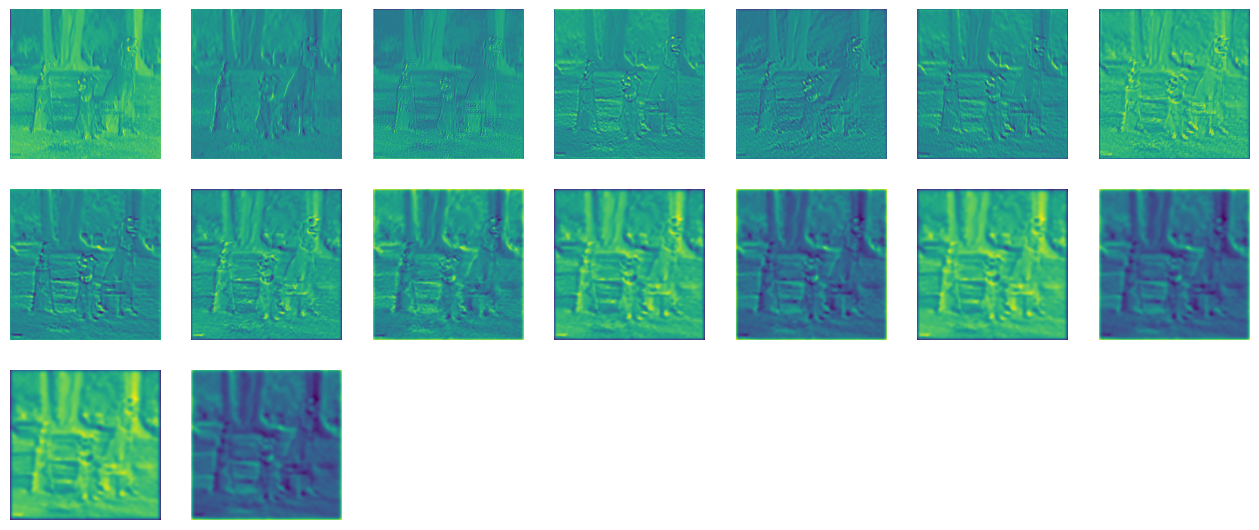

In [64]:
fig = plt.figure(figsize=(16, 16))
for i in range(len(processed)):
    a = fig.add_subplot(7, 7, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')